In [1]:
from concurrent.futures import ThreadPoolExecutor
import os
import pandas as pd

def procesar_archivo(ruta_archivo):
    print(f"Procesando archivo: {ruta_archivo}")

    archivo = os.path.basename(ruta_archivo)
    nombre_compuesto = archivo.split('_')[0]

    if archivo.endswith('.xlsx'):
        df = pd.read_excel(ruta_archivo)
    elif archivo.endswith('.csv'):
        df = pd.read_csv(ruta_archivo, delimiter=';')
    else:
        return None

    df = df.drop(['MAGNITUD', 'PUNTO_MUESTREO'], axis=1)
    df_melt = df.melt(id_vars=['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'ANNO', 'MES', 'DIA'],
                      var_name='HORA', value_name='VALOR')
    df_melt['HORA'] = df_melt['HORA'].str.extract('(\d+)').astype(int)
    df_melt['FECHA'] = pd.to_datetime(df_melt[['ANNO', 'MES', 'DIA', 'HORA']].rename(
        columns={'ANNO': 'year', 'MES': 'month', 'DIA': 'day', 'HORA': 'hour'}))
    df_melt.drop(['ANNO', 'MES', 'DIA', 'HORA'], axis=1, inplace=True)
    df_melt['COMPUESTO'] = nombre_compuesto
    df_melt = df_melt[['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'FECHA', 'COMPUESTO', 'VALOR']]
    print(f"Archivo {archivo} procesado.")
    return df_melt


años = [2018, 2019, 2021, 2022]
lista_datasets = []  
for año in años:
    ruta_carpeta = f"Dades/{año}/"
    print(f"Iniciando el procesamiento para el año {año}")
    rutas_archivos = [os.path.join(ruta_carpeta, archivo) for archivo in os.listdir(ruta_carpeta)]
    with ThreadPoolExecutor() as executor:
        resultados = list(executor.map(procesar_archivo, rutas_archivos))
    resultados = [df for df in resultados if df is not None]
    lista_datasets.extend(resultados)
    print(f"Finalizado el procesamiento para el año {año}.\n")


Iniciando el procesamiento para el año 2018
Procesando archivo: Dades/2018/C6H6_HH_2018.csv
Procesando archivo: Dades/2018/CO_HH_2018.csv
Procesando archivo: Dades/2018/NO2_HH_2018.csv
Procesando archivo: Dades/2018/NOx_HH_2018.csv
Procesando archivo: Dades/2018/NO_HH_2018.csv
Procesando archivo: Dades/2018/O3_HH_2018.csv
Procesando archivo: Dades/2018/PM10_HH_2018.csv
Procesando archivo: Dades/2018/PM25_HH_2018.csv
Procesando archivo: Dades/2018/SO2_HH_2018.csv
Archivo C6H6_HH_2018.csv procesado.
Archivo PM25_HH_2018.csv procesado.
Archivo CO_HH_2018.csv procesado.
Archivo PM10_HH_2018.csv procesado.
Archivo SO2_HH_2018.csv procesado.
Archivo O3_HH_2018.csv procesado.
Archivo NOx_HH_2018.csv procesado.
Archivo NO_HH_2018.csv procesado.
Archivo NO2_HH_2018.csv procesado.
Finalizado el procesamiento para el año 2018.

Iniciando el procesamiento para el año 2019
Procesando archivo: Dades/2019/C6H6_HH_2019.csv
Procesando archivo: Dades/2019/CO_HH_2019.csv
Procesando archivo: Dades/2019/NO

In [ ]:
df_final = pd.concat(lista_datasets, ignore_index=True)
lista_datasets = []
df_pivot = pd.pivot_table(df_final,
                          values='VALOR',
                          index=['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'FECHA'],
                          columns=['COMPUESTO'],
                          aggfunc='first').reset_index()


In [3]:
import os
path = 'Dades\Metainformacion2022.xlsx'
estaciones = pd.read_excel(path, sheet_name='Estaciones')
estaciones = estaciones.drop(['COD_LOCAL', 'COD_ESTACION_DEM', 'N_RED', 'NOMBRE', 'FECHA_INI', 'FECHA_FIN', 'N_CCAA', 'N_PROVINCIA', 'N_MUNICIPIO', 'TIPO_SUBAREA_RURAL','EST', 'DIRECCION', ], axis=1)

In [4]:

columnas_de_interes = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'LATITUD_G', 'LONGITUD_G', 'ALTITUD',	'TIPO_ESTACION',	'TIPO_AREA',	'ZONA']
df_estaciones_reducido = estaciones[columnas_de_interes]
df_final = pd.merge(df_pivot, df_estaciones_reducido, how='left', on=['PROVINCIA', 'MUNICIPIO', 'ESTACION'])
df_final = df_final.drop(['PROVINCIA', 'MUNICIPIO', 'ESTACION','20','31','42','431','44'], axis=1)
porcentaje_nan = (df_final.isna().sum() / len(df_final)) * 100
print(porcentaje_nan)
print(df_final.isna().sum())

FECHA             0.000000
C6H6             87.418008
CO               62.756979
NO               55.194657
NO2               9.602163
NOx              35.116475
O3               25.176713
PM10             37.571426
PM25             69.613341
SO2              27.360131
LATITUD_G         4.921349
LONGITUD_G        4.921349
ALTITUD           4.921349
TIPO_ESTACION     4.921349
TIPO_AREA         4.921349
ZONA              5.095797
dtype: float64
FECHA                   0
C6H6             17038803
CO               12232077
NO               10758091
NO2               1871575
NOx               6844616
O3                4907239
PM10              7323115
PM25             13568463
SO2               5332813
LATITUD_G          959229
LONGITUD_G         959229
ALTITUD            959229
TIPO_ESTACION      959229
TIPO_AREA          959229
ZONA               993231
dtype: int64


In [5]:
import numpy as np
df_final = df_final.dropna(subset=['LATITUD_G', 'LONGITUD_G'])
def reemplazar_negativos(valor):
    if pd.isna(valor):
        return valor
    return max(0, valor)
columnas_a_modificar = [col for col in df_final.columns if col not in ['LATITUD_G', 'LONGITUD_G', 'FECHA', 'TIPO_ESTACION', 'TIPO_AREA', 'ZONA']]
df_final[columnas_a_modificar] = df_final[columnas_a_modificar].applymap(reemplazar_negativos)
print(df_final.describe())

C:\Users\marcs\AppData\Local\Temp\ipykernel_15000\3303518042.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_final[columnas_a_modificar] = df_final[columnas_a_modificar].applymap(reemplazar_negativos)


                               FECHA          C6H6            CO  \
count                       18531953  2.425052e+06  7.114548e+06   
mean   2020-07-25 01:50:04.592446720  4.654799e-01  3.044308e-01   
min              2018-01-01 01:00:00  0.000000e+00  0.000000e+00   
25%              2019-01-18 21:00:00  9.000000e-02  1.300000e-01   
50%              2021-01-29 06:00:00  2.000000e-01  2.470000e-01   
75%              2022-01-17 09:00:00  6.000000e-01  4.000000e-01   
max              2023-01-01 00:00:00  2.009000e+02  2.695000e+02   
std                              NaN  1.010784e+00  3.758710e-01   

                 NO           NO2           NOx            O3          PM10  \
count  8.064933e+06  1.678721e+07  1.191196e+07  1.412063e+07  1.151511e+07   
mean   7.071996e+00  1.469690e+01  2.448232e+01  5.954472e+01  2.010267e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  4.000000e+00  6.000000e+00  4.000000e+01  9.000000

In [ ]:
df_final = df_final.query('not (27.6 <= LATITUD_G <= 29.4 and -18.3 <= LONGITUD_G <= -13.3)')

In [ ]:
df_final_filtrado = df_final

In [8]:
numeric_cols = df_final_filtrado.select_dtypes(include=['number']).columns
df_final_filtrado['FECHA'] = pd.to_datetime(df_final_filtrado['FECHA'])
df_final_filtrado = df_final_filtrado.sort_values(['FECHA', 'LATITUD_G', 'LONGITUD_G'])
def interpolar_grupo(grupo):
    grupo['diff_hours'] = grupo['FECHA'].diff().dt.total_seconds() / 3600
    
    for col in numeric_cols:
        mask = grupo['diff_hours'] <= 3 
        grupo.loc[mask, col] = grupo.loc[mask, col].interpolate(method='linear')
    grupo.drop('diff_hours', axis=1, inplace=True)
    
    return grupo

df_interpolado = df_final_filtrado.groupby(['LATITUD_G', 'LONGITUD_G']).apply(interpolar_grupo).reset_index(drop=True)


C:\Users\marcs\AppData\Local\Temp\ipykernel_15000\4066266486.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interpolado = df_final_filtrado.groupby(['LATITUD_G', 'LONGITUD_G']).apply(interpolar_grupo).reset_index(drop=True)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoLars
import pandas as pd
import numpy as np

numeric_cols = df_final_filtrado.select_dtypes(include=['number']).columns
iterative_imputer = IterativeImputer(max_iter=15, random_state=0)
df_numeric_imputed = iterative_imputer.fit_transform(df_final_filtrado[numeric_cols])
df_numeric_imputed = pd.DataFrame(df_numeric_imputed, columns=numeric_cols)
df_final_filtrado_copy1 = df_final_filtrado.copy()
df_final_filtrado_copy1.reset_index(drop=True, inplace=True)
df_numeric_imputed.reset_index(drop=True, inplace=True)
df_final_filtrado_copy1[numeric_cols] = df_numeric_imputed

iterative_imputer_lasso_lars = IterativeImputer(estimator=LassoLars(), max_iter=10, random_state=0)
df_numeric_imputed_lasso_lars = iterative_imputer_lasso_lars.fit_transform(df_final_filtrado[numeric_cols])
df_numeric_imputed_lasso_lars = pd.DataFrame(df_numeric_imputed_lasso_lars, columns=numeric_cols)
df_final_filtrado_copy2 = df_final_filtrado.copy()
df_final_filtrado_copy2.reset_index(drop=True, inplace=True)
df_numeric_imputed_lasso_lars.reset_index(drop=True, inplace=True)
df_final_filtrado_copy2[numeric_cols] = df_numeric_imputed_lasso_lars

correlations = {}
for col in numeric_cols:
    corr = np.corrcoef(df_final_filtrado_copy1[col], df_final_filtrado_copy2[col])[0, 1]
    correlations[col] = corr

correlations_df = pd.DataFrame(list(correlations.items()), columns=['Column', 'Correlation'])


In [10]:
numeric_cols = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2']
df_final_filtrado_average = df_final_filtrado_copy1.copy()
df_final_filtrado_average[numeric_cols] = df_final_filtrado_copy1[numeric_cols]
def replace_negative_with_zero(x):
    return max(x, 0)
for col in numeric_cols:
    df_final_filtrado_average[col] = df_final_filtrado_average[col].apply(replace_negative_with_zero)

In [11]:
df_final_filtrado_average

,FECHA,C6H6,CO,NO,NO2,NOx,O3,PM10,PM25,SO2,LATITUD_G,LONGITUD_G,ALTITUD,TIPO_ESTACION,TIPO_AREA,ZONA
0,2018-01-01 01:00:00,0.588779,0.655000,1.000000,11.000000,12.000000,57.000000,24.150000,6.745848,4.000000,36.13623,-5.45343,24.0,INDUSTRIAL,URBANA,INDUSTRIAL
1,2018-01-01 01:00:00,0.602762,0.377723,1.000000,9.000000,11.000000,62.000000,29.400000,10.141397,11.000000,36.15937,-5.34836,1.0,INDUSTRIAL,URBANA,RESIDENCIAL
2,2018-01-01 01:00:00,0.562268,0.358655,8.000000,16.000000,29.000000,60.386023,26.780738,9.775924,9.000000,36.16170,-5.44260,1.0,INDUSTRIAL,URBANA,RESIDENCIAL/INDUSTRIAL
3,2018-01-01 01:00:00,0.556702,0.365603,6.000000,16.000000,24.000000,61.731254,26.323490,9.736344,10.000000,36.17315,-5.34194,8.0,FONDO,URBANA,RESIDENCIAL
4,2018-01-01 01:00:00,0.562104,0.390191,7.710489,16.540273,25.316885,61.642013,25.809595,9.953648,10.000000,36.17470,-5.43277,1.0,INDUSTRIAL,URBANA,INDUSTRIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792649,2023-01-01 00:00:00,0.501758,0.510000,8.517005,18.000000,30.928176,49.000000,28.000000,11.855483,1.000000,43.55890,-5.92750,12.0,TRAFICO,URBANA,RESIDENCIAL/COMERCIAL
16792650,2023-01-01 00:00:00,0.000000,0.080000,-3.426450,6.000000,10.699514,33.000000,12.000000,1.000000,1.793560,43.57050,-5.95830,8.0,FONDO,SUBURBANA,RESIDENCIAL/INDUSTRIAL
16792651,2023-01-01 00:00:00,0.517745,0.344774,6.475323,15.020226,25.476176,46.257465,24.000000,11.442490,3.722505,43.57920,-5.92730,6.0,INDUSTRIAL,SUBURBANA,INDUSTRIAL
16792652,2023-01-01 00:00:00,0.183652,0.318280,4.034425,11.947279,19.130305,49.775181,12.000000,5.000000,3.393668,43.65910,-7.36320,173.0,FONDO,URBANA,RESIDENCIAL/INDUSTRIAL/NATURALEZA


In [12]:
print(df_final_filtrado_average.describe())

                               FECHA          C6H6            CO  \
count                       16792654  1.679265e+07  1.679265e+07   
mean   2020-07-24 22:47:28.670113024  4.799153e-01  2.921548e-01   
min              2018-01-01 01:00:00  0.000000e+00  0.000000e+00   
25%              2019-01-18 19:00:00  1.700000e-01  1.830384e-01   
50%              2021-01-28 19:00:00  4.000000e-01  2.602727e-01   
75%              2022-01-17 19:00:00  6.506887e-01  3.613494e-01   
max              2023-01-01 00:00:00  2.172455e+02  2.695000e+02   
std                              NaN  5.672940e-01  2.754212e-01   

                 NO           NO2           NOx            O3          PM10  \
count  1.679265e+07  1.679265e+07  1.679265e+07  1.679265e+07  1.679265e+07   
mean   6.359221e+00  1.507927e+01  2.471332e+01  5.744914e+01  1.898785e+01   
min   -2.770444e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  4.000000e+00  7.000000e+00  4.011138e+01  1.200000

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
coordenadas_unicas = df_final_filtrado_average[['LATITUD_G', 'LONGITUD_G']].drop_duplicates()

primera_estacion = coordenadas_unicas.iloc[250]  

estacion_seleccionada = df_final_filtrado_average[
    (df_final_filtrado_average['LATITUD_G'] == primera_estacion['LATITUD_G']) &
    (df_final_filtrado_average['LONGITUD_G'] == primera_estacion['LONGITUD_G'])
]

estacion_seleccionada.loc[:, 'FECHA'] = pd.to_datetime(estacion_seleccionada['FECHA'])

estacion_seleccionada = estacion_seleccionada.set_index('FECHA')

fecha_inicio = '2021-09-07'
fecha_fin = '2021-09-13'
estacion_seleccionada = estacion_seleccionada[fecha_inicio:fecha_fin]

contaminantes = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2']


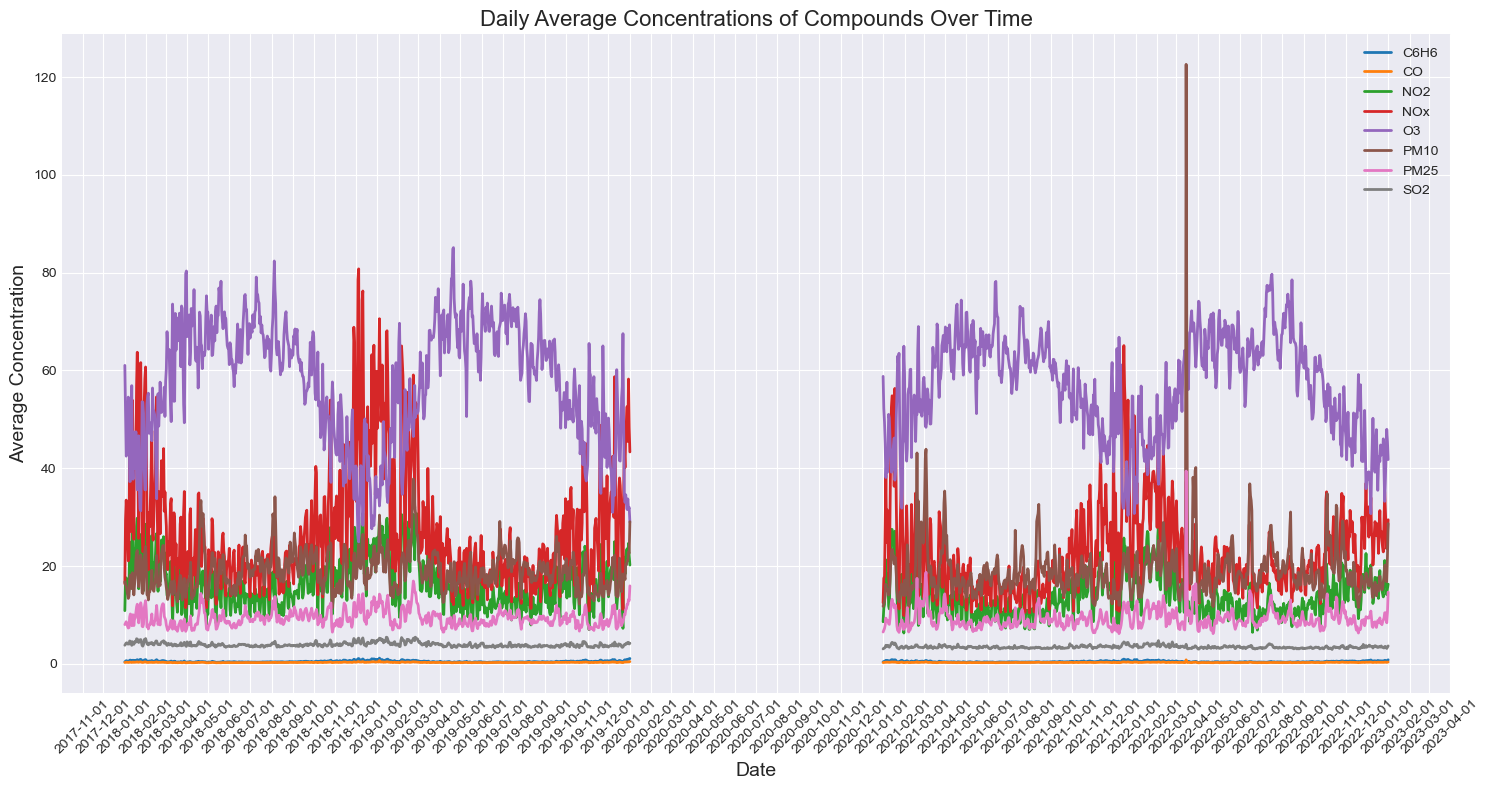

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


df_temporal = df_final_filtrado_average.copy()
df_temporal['FECHA'] = pd.to_datetime(df_temporal['FECHA'])
df_temporal = df_temporal.set_index('FECHA')

contaminantes = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2']
medias_diarias = df_temporal[contaminantes].resample('D').mean()

plt.figure(figsize=(15, 8))
for contaminante in contaminantes:
    plt.plot(medias_diarias.index, medias_diarias[contaminante], label=contaminante, marker='', linewidth=2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Daily Average Concentrations of Compounds Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Concentration', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

          C6H6        CO       NO2       NOx        O3      PM10      PM25  \
C6H6  1.000000  0.894869  0.836097  0.904338 -0.915174  0.216329  0.498959   
CO    0.894869  1.000000  0.771539  0.840934 -0.786302  0.554306  0.733321   
NO2   0.836097  0.771539  1.000000  0.952261 -0.694312  0.290443  0.523760   
NOx   0.904338  0.840934  0.952261  1.000000 -0.758965  0.289339  0.540220   
O3   -0.915174 -0.786302 -0.694312 -0.758965  1.000000  0.008092 -0.243467   
PM10  0.216329  0.554306  0.290443  0.289339  0.008092  1.000000  0.941677   
PM25  0.498959  0.733321  0.523760  0.540220 -0.243467  0.941677  1.000000   
SO2   0.660691  0.619386  0.837410  0.807399 -0.425150  0.302320  0.486970   

           SO2  
C6H6  0.660691  
CO    0.619386  
NO2   0.837410  
NOx   0.807399  
O3   -0.425150  
PM10  0.302320  
PM25  0.486970  
SO2   1.000000  


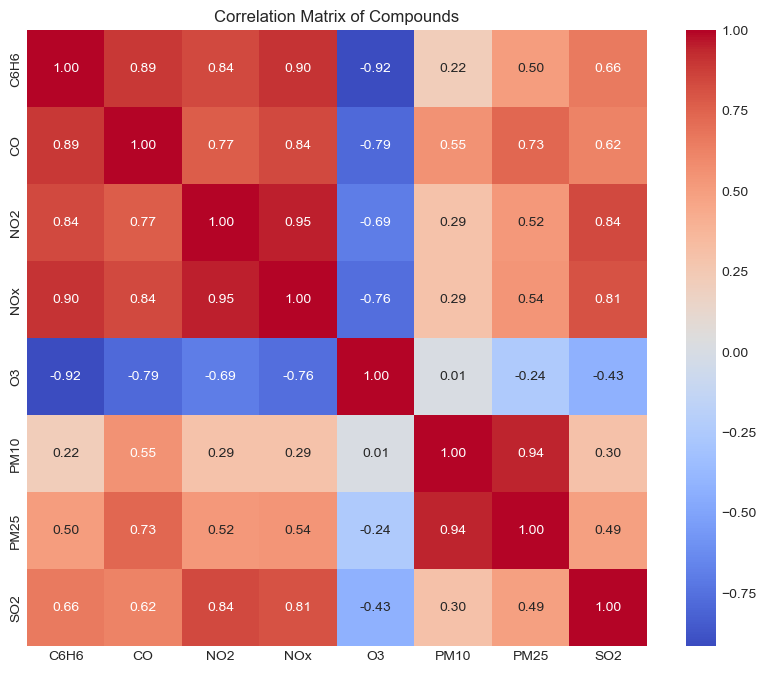

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_temporal = df_final_filtrado_average.copy()

df_temporal['FECHA'] = pd.to_datetime(df_temporal['FECHA'])
df_temporal = df_temporal.set_index('FECHA')
contaminantes = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2']
medias_diarias = df_temporal[contaminantes].resample('D').mean()
correlacion = medias_diarias.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Compounds')
plt.show()

In [ ]:
df_final_filtrado_average = df_final_filtrado_average.dropna(subset=['FECHA'])
df_one_hot = pd.get_dummies(df_final_filtrado_average, columns=['TIPO_ESTACION', 'TIPO_AREA', 'ZONA'])

columns_to_convert = ['TIPO_ESTACION', 'TIPO_AREA', 'ZONA']
dummy_columns = [col for col in df_one_hot.columns if any(c in col for c in columns_to_convert)]
df_one_hot[dummy_columns] = df_one_hot[dummy_columns].astype(int)
df_one_hot = df_one_hot.sort_values(by=['FECHA', 'LATITUD_G', 'LONGITUD_G'], ascending=[True, True, True])

In [45]:
df_one_hot.to_csv('Dades/estaciones_final_inputed.csv', index=False)